# 等离子体电子声不稳定性：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
import mpmath as mp
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{(v-u_s)^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{(v-u_f)^2}{2T} \right)^{-\kappa_f} $$
$$ f_f(\kappa \rightarrow \infty) = \frac{n_f}{\sqrt{2\pi T}} \exp \left[ -\frac{(v-u_s)^2}{2 T}\right]$$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 + \xi_f Z(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega/k-u_\sigma}{\theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [22]:
def fk(v):
    r_s = ( 1 + (v-u_s)**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + (v-u_f)**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
#     r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_1KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) )
    return [r.real,r.imag]

def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp

def PrintParas():
    paras_table = PrettyTable(['a='+str(a),'n','kappa','wp','theta','lambda_D','u'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4),round(u_s,4)])
    paras_table.add_row(['f',n_f,'inf',round(wp_f,4),round(v_f,4),round(l_f,4),round(u_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    T = 0.5*m*v_f**2
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    kappa_s = 1.5/(1-v_s**2/v_f**2)
#     v_s = np.sqrt((2-3/kappa_s)*T/m)
#     v_f = np.sqrt(2*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,kappa_s,T

### PDR中的KW分支和LW分支

In [36]:
# 等离子体基本参数
n = 1
q = 1
m = 1

n_s = 0.5
v_s = 0.1
v_f = 1

n_f,l_s,l_f,wp_s,wp_f,kappa_s,T=SetParas()
u_s = 0
a = 10
u_f = 0
PrintParas()

+------+-----+--------------------+--------+-------+----------+---+
| a=10 |  n  |       kappa        |   wp   | theta | lambda_D | u |
+------+-----+--------------------+--------+-------+----------+---+
|  s   | 0.5 | 1.5151515151515151 | 0.7071 |  0.1  |   1.0    | 0 |
|  f   | 0.5 |        inf         | 0.7071 |   1   |   1.0    | 0 |
+------+-----+--------------------+--------+-------+----------+---+


- 计算a的初值

In [37]:
kappa_s_list = np.linspace(1.501,kappa_s,num=50)
n_s_list = np.linspace(0.1,n_s,num=10)
a_list = np.linspace(0,a,num=10)

# n_s = 0.1
n_f,l_s,l_f,wp_s,wp_f,kappa_s,T=SetParas()
# kappa_s = 1.501
wr_kw_guess = 0.032
wi_kw_guess = -0.007
wr_kw2_guess = -0.032
wi_kw2_guess = -0.007
wr_lw_guess = -1.002
wi_lw_guess = 0.0
wr_lw2_guess = 1.0043
wi_lw2_guess = 0.0

for a_each in tqdm(a_list,position=0,leave=True):
    u_f = a_each * v_s
    s_kw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = s_kw.x[0]
        wi_kw_guess = s_kw.x[1]
    s_kw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw2_guess,wi_kw2_guess])
    if s_kw2.success==True:
        wr_kw2_guess = s_kw2.x[0]
        wi_kw2_guess = s_kw2.x[1]
    s_lw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw_guess = s_lw.x[0]
        wi_lw_guess = s_lw.x[1]
    s_lw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw2_guess,wi_lw2_guess])
    if s_lw.success==True:
        wr_lw2_guess = s_lw2.x[0]
        wi_lw2_guess = s_lw2.x[1]

# for kappa_s_each in tqdm(kappa_s_list,position=0,leave=True):
#     kappa_s = kappa_s_each
#     n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
#     u_f = a * v_s
#     s_kw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess])
#     if s_kw.success==True:
#         wr_kw_guess = s_kw.x[0]
#         wi_kw_guess = s_kw.x[1]
#     s_kw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw2_guess,wi_kw2_guess])
#     if s_kw2.success==True:
#         wr_kw2_guess = s_kw2.x[0]
#         wi_kw2_guess = s_kw2.x[1]
#     s_lw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess])
#     if s_lw.success==True:
#         wr_lw_guess = s_lw.x[0]
#         wi_lw_guess = s_lw.x[1]
#     s_lw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw2_guess,wi_lw2_guess])
#     if s_lw.success==True:
#         wr_lw2_guess = s_lw2.x[0]
#         wi_lw2_guess = s_lw2.x[1]

# for n_s_each in tqdm(n_s_list,position=0,leave=True):
#     n_s = n_s_each
#     n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
#     u_f = a * v_s
#     s_kw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess])
#     if s_kw.success==True:
#         wr_kw_guess = s_kw.x[0]
#         wi_kw_guess = s_kw.x[1]
#     s_kw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw2_guess,wi_kw2_guess])
#     if s_kw2.success==True:
#         wr_kw2_guess = s_kw2.x[0]
#         wi_kw2_guess = s_kw2.x[1]
#     s_lw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess])
#     if s_lw.success==True:
#         wr_lw_guess = s_lw.x[0]
#         wi_lw_guess = s_lw.x[1]
#     s_lw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw2_guess,wi_lw2_guess])
#     if s_lw.success==True:
#         wr_lw2_guess = s_lw2.x[0]
#         wi_lw2_guess = s_lw2.x[1]

# kappa_s = kappa_s_list[-1]
# n_s = n_s_list[-1]
PrintParas()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.48it/s]

+------+-----+--------------------+--------+-------+----------+-----+
| a=10 |  n  |       kappa        |   wp   | theta | lambda_D |  u  |
+------+-----+--------------------+--------+-------+----------+-----+
|  s   | 0.1 | 1.5151515151515151 | 0.3162 |  0.1  |  2.2361  |  0  |
|  f   | 0.9 |        inf         | 0.9487 |   1   |  0.7454  | 1.0 |
+------+-----+--------------------+--------+-------+----------+-----+


- 计算LW和EAW的$\omega$和$\gamma$

In [38]:
k_list = np.linspace(0.1,2.0,num=100)
u_f = a*v_s

wr_kw_list = []
wi_kw_list = []
wr_kw2_list = []
wi_kw2_list = []
wr_lw_list = []
wi_lw_list = []
wr_lw2_list = []
wi_lw2_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = s_kw.x[0]
        wi_kw_guess = s_kw.x[1]
        wr_kw_list.append(s_kw.x[0])
        wi_kw_list.append(s_kw.x[1])
    else:
        wr_kw_list.append(np.nan)
        wi_kw_list.append(np.nan)
    s_kw2 = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw2_guess,wi_kw2_guess])
    if s_kw2.success==True:
        wr_kw2_guess = round(s_kw2.x[0],6)
        wi_kw2_guess = round(s_kw2.x[1],6)
        wr_kw2_list.append(s_kw2.x[0])
        wi_kw2_list.append(s_kw2.x[1])
    else:
#         print("kw, error for k=",k_each)
        wr_kw2_list.append(np.nan)
        wi_kw2_list.append(np.nan)
        
    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess],method='hybr')
    if s_lw.success==True:
        wr_lw_guess = round(s_lw.x[0],6)
        wi_lw_guess = round(s_lw.x[1],6)
        wr_lw_list.append(s_lw.x[0])
        wi_lw_list.append(s_lw.x[1])
    else:
#         print("lw, error for k=",k_each)
        wr_lw_list.append(np.nan)
        wi_lw_list.append(np.nan)
    s_lw2 = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw2_guess,wi_lw2_guess],method='hybr')
    if s_lw2.success==True:
        wr_lw2_guess = round(s_lw2.x[0],6)
        wi_lw2_guess = round(s_lw2.x[1],6)
        wr_lw2_list.append(s_lw2.x[0])
        wi_lw2_list.append(s_lw2.x[1])
    else:
#         print("lw, error for k=",k_each)
        wr_lw2_list.append(np.nan)
        wi_lw2_list.append(np.nan)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.54it/s]


In [39]:
# wr_kw_theo = wr_kw_list

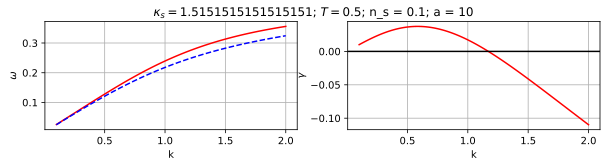

In [40]:
b_kw = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
b_kw2 = np.array(wi_kw2_list)/abs(np.array(wr_kw2_list)/2/np.pi)
b_lw = np.array(wi_lw_list)/abs(np.array(wr_lw_list)/2/np.pi)
b_lw2 = np.array(wi_lw2_list)/abs(np.array(wr_lw2_list)/2/np.pi)

fig = plt.figure(figsize=(10,2))
ax1 = plt.subplot(121)
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
ax1.grid()
ax2 = plt.subplot(122)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()
# ax3 = plt.subplot(133)
# ax3.axhline(-1,linestyle='--')
# ax3.axhline(1,linestyle='--')
# ax3.set_xlabel('k')
# ax3.set_ylabel(r'$\gamma/\frac{\omega}{2\pi}$')
# ax3.grid()
plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T)+"; n_s = "+str(n_s)+"; a = "+str(a))

ax1.plot(k_list,wr_kw_list,'-',color='red')
ax1.plot(k_list,wr_kw_theo,'--',color='blue')
# ax1.plot(k_list,wr_kw2_list,'.',color='orange')
# ax1.plot(k_list,wr_lw_list,'.',color='blue')
# ax1.plot(k_list,wr_lw2_list,'.',color='green')

# ax1.plot(k_list[0:20],k_list[0:20]*u_f/(1+n_s)+k_list[0:20]*u_f,':',color='black')
# ax1.plot(k_list[0:20],k_list[0:20]*u_f,':',color='black')
# ax1.plot(k_list,k_list*v_f,':',color='black')

ax2.plot(k_list,wi_kw_list,color='red')
ax2.axhline(0,color='black')
# ax2.plot(k_list,wi_kw2_list,color='orange')
# ax2.plot(k_list,wi_lw_list,color='blue')

# ax3.plot(k_list,b_kw,color='red')
# ax3.plot(k_list,b_kw2,color='orange')
# ax3.plot(k_list,b_lw,color='blue')
# ax3.plot(k_list,b_lw2,color='green')

plt.show()

### KW波不稳定性：$\gamma >0$
令$a = \frac{u_f}{v_s}$

#### $r_{max}(n_s,a)$图

In [43]:
n_s_list = np.linspace(0.1,0.8,num=16)

In [44]:
n_s=n_s_list[0]
kappa_s = 1.501
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
u_f = a_list[0]*v_s
PrintParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.032,-0.007])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.046,-0.01])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]

+------+-----+-------+--------+--------+----------+-----+
| a=20 |  n  | kappa |   wp   | theta  | lambda_D |  u  |
+------+-----+-------+--------+--------+----------+-----+
|  s   | 0.1 | 1.501 | 0.3162 | 0.0365 |  3.1623  |  0  |
|  f   | 0.9 |  inf  | 0.9487 | 1.4142 |  1.0541  | 0.0 |
+------+-----+-------+--------+--------+----------+-----+
k =  0.1
True [ 0.03268755 -0.00771821]
True [ 0.03268755 -0.00771821]


In [45]:
r_max_mat = []
wr_k0 = 0.0
wi_k0 = 0.0
wr_a0 = 0.0
wi_a0 = 0.0
u_f = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    r_max_list = []
    for a_each in a_list:
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        u_f = a_each*v_s
        
        r_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                r_list=np.append(r_list,s.x[1])
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if a_each == a_list[0]:
                    wr_a0 = wr_k0
                    wi_a0 = wi_k0
        r_max_list.append(np.amax(r_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    r_max_mat.append(r_max_list)
    wr_kw_guess = wr_a0
    wi_kw_guess = wi_a0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:50<00:00,  6.91s/it]


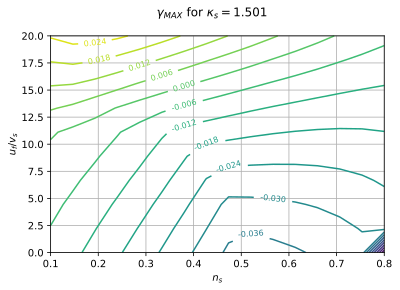

In [46]:
a_grid,n_s_grid=np.meshgrid(a_list,n_s_list)
c = plt.contour(n_s_grid,a_grid,r_max_mat,levels=20)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $\kappa_s=$'+str(kappa_s))
plt.xlabel('$n_s$')
plt.ylabel('$u_f/v_s$')
plt.grid()
plt.show()

#### $r_{max}(n_s,\kappa_s)$图

In [51]:
kappa_s_list = np.linspace(1.51,2.5,num=15)

In [52]:
n_s=n_s_list[0]
T = 1
kappa_s = kappa_s_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
a = 20
u_f = a*v_s
PrintParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.052,0.0056])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.127,-1.202])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_lw_guess = s1.x[0]
wi_lw_guess = s1.x[1]

+------+-----+-------+--------+--------+----------+--------+
| a=20 |  n  | kappa |   wp   | theta  | lambda_D |   u    |
+------+-----+-------+--------+--------+----------+--------+
|  s   | 0.1 |  1.51 | 0.3162 | 0.1151 |  3.1623  |   0    |
|  f   | 0.9 |  inf  | 0.9487 | 1.4142 |  1.0541  | 2.3017 |
+------+-----+-------+--------+--------+----------+--------+
k =  0.1
True [0.03618609 0.04204183]
True [ 1.22753296e+00 -1.88298357e-05]


In [53]:
r_max_mat = []
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    r_max_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        v_s = np.sqrt((2-3/kappa_s)*T/m)
        v_f = np.sqrt(2*T/m)
        u_f = a*v_s
        r_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                r_list=np.append(r_list,s.x[1])
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        r_max_list.append(np.amax(r_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    r_max_mat.append(r_max_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:32<00:00, 17.02s/it]


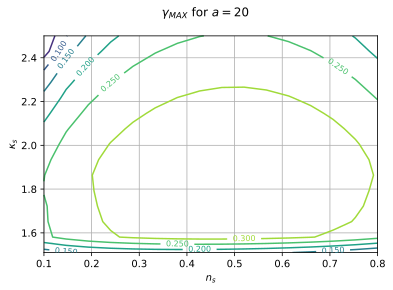

In [54]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
c = plt.contour(n_s_grid,kappa_s_grid,r_max_mat)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $a=$'+str(a))
plt.xlabel('$n_s$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()

## 模拟验证

### 模拟参数设定

In [86]:
T = 1
n_s = 0.75
kappa_s = 1.52
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
u_f = a*v_s
PrintParas()

k = 0.7
L = 2*np.pi/k

vmax = 10 # 速度最大值
nx = 201
nv = 2001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.02
max_steps  = 5000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

+------+------+-------+-------+--------+----------+--------+
| a=10 |  n   | kappa |   wp  | theta  | lambda_D |   u    |
+------+------+-------+-------+--------+----------+--------+
|  s   | 0.75 |  1.52 | 0.866 | 0.1622 |  1.1547  |   0    |
|  f   | 0.25 |  inf  |  0.5  | 1.4142 |   2.0    | 1.6222 |
+------+------+-------+-------+--------+----------+--------+
3
limited time= 897.5979010256551
real time =  100.0


In [87]:
# 计算特定k的w,r
k_idx = int( (k-k_list[0])/(k_list[1]-k_list[0]) )
s1_k = op.root(lambda w:PDR_2KE(w,k),[wr_kw_list[k_idx],wi_kw_list[k_idx]])
s2_k = op.root(lambda w:PDR_2KE(w,k),[wr_kw2_list[k_idx],wi_kw2_list[k_idx]])
s3_k = op.root(lambda w:PDR_2KE(w,k),[wr_lw_list[k_idx],wi_lw_list[k_idx]])
s4_k = op.root(lambda w:PDR_2KE(w,k),[wr_lw2_list[k_idx],wi_lw2_list[k_idx]])
print(s1_k.success,s1_k.x)
print(s2_k.success,s2_k.x)
print(s3_k.success,s3_k.x)
print(s4_k.success,s4_k.x)
w_kw = s1_k.x[0]
r_kw = s1_k.x[1]
w_kw2 = s2_k.x[0]
r_kw2 = s2_k.x[1]
w_lw = s3_k.x[0]
r_lw = s3_k.x[1]

True [0.76759509 0.02708941]
True [-0.02724637 -0.9608936 ]
True [-0.95024057 -0.04708441]
True [ 2.39618521 -0.74189371]


### KW条件检验
- $\gamma_{KW} < \gamma_{LW}^{hot}$

In [88]:
print('r_kw = ',round(r_kw,6))
print('r_lw = ',round(r_lw,6))

r_kw =  0.027089
r_lw =  -0.047084


- $k\lambda_h \le 1$

In [89]:
print('k*l_D_f = ',round(k*l_f,6))

k*l_D_f =  1.4


- $\gamma_{KW} < \omega_r/(2\pi)$

In [90]:
print('r_kw   = ',round(r_kw,6))
print('wr/2/pi = ',round(w_kw/2/np.pi,6))

r_kw   =  0.027089
wr/2/pi =  0.122167


### 模拟结果

In [91]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

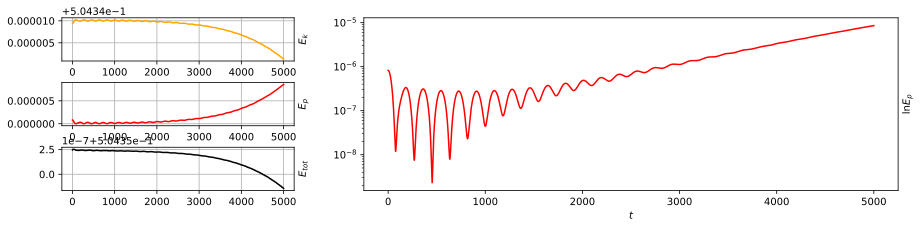

In [92]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [93]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [94]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

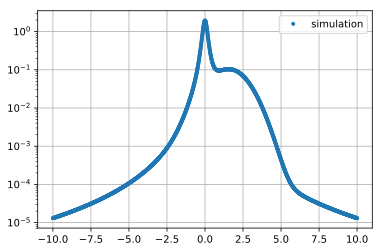

In [82]:
plt.plot(v,fv0,'.',label='simulation')
# plt.plot(v,fk(v),':',label='theory')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [83]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

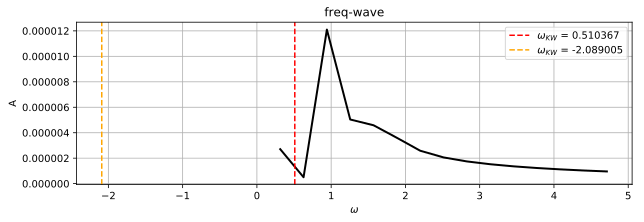

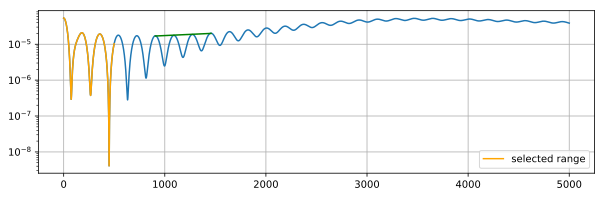

In [84]:
start = 000
end = 500

indexes, _ = scipy.signal.find_peaks(dataep, distance=1)
xep = indexes[4:8:1]
yep = np.log(dataep[xep])
# xep = t[start:end]
# yep = np.log(dataep[start:end])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],w_kw,-s4_k.x[0])
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

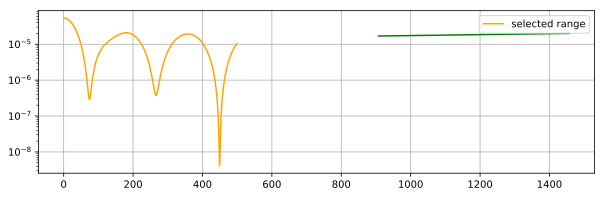

In [85]:
fig = plt.figure(figsize=(10,3))
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [83]:
wr0_err = abs(wr_sim-w_kw)/w_kw*100
wr1_err = abs(wr_sim-w_lw)/w_lw*100
wi0_err = abs((wi_sim-r_kw)/r_kw)*100
wi1_err = abs((wi_sim-r_lw)/r_lw)*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(w_kw,6),round(r_kw,6)])
com_table.add_row(['Theory1',round(w_lw,6),round(r_lw,6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(wi_sim,6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
com_table.add_row(['Error1(%)',round(wr1_err,6),round(abs(wi1_err),6)])
print(com_table)

+------------+-----------+------------+
| EAW: k=0.9 |     wr    |     wi     |
+------------+-----------+------------+
|  Theory0   |  0.565964 |  0.006966  |
|  Theory1   |  2.330319 | -0.904693  |
| Simulation |  0.620868 |  0.003411  |
| Error0(%)  |  9.701024 | 51.028937  |
| Error1(%)  | 73.356944 | 100.377072 |
+------------+-----------+------------+
